In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.stats as stats
import matplotlib.patches as patches
import plotly.express as px

from utils import dibuja_covar, dibuja_covar_ax

plt.style.use('ggplot')


In [2]:
#definimos los ticvkers de los activos que vamos a usar
assets = ['AAPL', 'APA', 'CMCSA', 'CPB', 'JCI', 'MO', 'MSFT', 'TGT']

In [3]:
# Nos bajamos los precios de cierre ajustados entre dos fechas
start = '1990-01-02'
end = '2022-12-31'

prices = yf.download(assets, start=start, end=end)['Adj Close']
ret = prices.pct_change().dropna()

[*********************100%%**********************]  8 of 8 completed


$$\epsilon_{\mu} = \frac{\sigma}{\sqrt{T}}$$

donde:
-  $\epsilon_{\mu}$ es el error cometido en la estimación de la media

- $\sigma$ es la volatilidad del activo

- $T$ es la longitud del periodo de medida

In [46]:
years = ret.index.year.unique()
years_str = [str(year) for year in years]
lista_de_listas = list(zip(years_str[:-1], years_str[1:]))
# Convertir las tuplas en listas
lista_de_listas = [list(tupla) for tupla in lista_de_listas]
lista_de_listas[0]

['1990', '1991']

In [60]:
years = ret.index.year.unique()
lista_de_listas = list(zip(years[:-1], years[1:]))
# Convertir las tuplas en listas
lista_de_listas = [list(tupla) for tupla in lista_de_listas]
lista_de_listas[0]
ret[ret.index.year.isin(lista_de_listas[0])]

[1990, 1991]

Calculamos los errores cometidos cuuando empleamos periodos de un año. En este caso, como $T=1$, el error es igual a la volatilidad del activo.

In [16]:
years = ret.index.year.unique()
years_str = [str(year) for year in years]

mu_año = pd.DataFrame(index=years, columns=assets)
error_mu = pd.DataFrame(index=years, columns=assets)

for año in years:
    ret_year = ret.loc[str(año)]
    mu_tmp = ret_year.mean()
    mu_año.loc[año] = mu_tmp*252
    std_tmp = ret_year.std()*np.sqrt(252)
    # T = ret_year.shape[0]
    # eps_mu = std_tmp / np.sqrt(T)
    error_mu.loc[año] = std_tmp


In [15]:
fig = px.line(error_mu, x=error_mu.index, y=error_mu.columns, title="ERROR COMETIDO EN LOS RETORNOS ANUALES ESPERADOS")

# Cambiar los títulos de los ejes
# Establecer el título del eje x
fig.update_layout(xaxis_title="Año", font_family="serif")
fig.update_layout(yaxis_title="Error (€)", font_family="serif")
#fig.set_yaxis_title("Error (€)")

# Mostrar la gráfica
fig.show()

In [17]:
error_mu.head(3)

,AAPL,APA,CMCSA,CPB,JCI,MO,MSFT,TGT
Date,,,,,,,,
1990,0.434349,0.428483,0.495305,0.267849,0.332913,0.263514,0.387761,0.265724
1991,0.464603,0.389394,0.398971,0.258193,0.346367,0.224188,0.367821,0.254897
1992,0.355329,0.363375,0.347181,0.262157,0.259575,0.185438,0.343219,0.262702


In [18]:
mu_año.head(3)

,AAPL,APA,CMCSA,CPB,JCI,MO,MSFT,TGT
Date,,,,,,,,
1990,0.249773,-0.062925,-0.14921,0.111736,-0.110109,0.260562,0.602917,-0.06827
1991,0.388052,0.173762,0.330501,0.421688,-0.153712,0.489879,0.861497,0.130033
1992,0.129228,0.247297,0.212605,0.049776,0.227304,0.00718,0.198058,0.257769


In [19]:
(error_mu/mu_año).head(3)

,AAPL,APA,CMCSA,CPB,JCI,MO,MSFT,TGT
Date,,,,,,,,
1990,1.738977,-6.809416,-3.31951,2.397148,-3.023486,1.011329,0.643141,-3.892264
1991,1.197272,2.240965,1.207172,0.612286,-2.253346,0.45764,0.426955,1.960253
1992,2.749626,1.469387,1.632982,5.26677,1.141971,25.82567,1.732918,1.019135


In [30]:
error_mu_pct = np.abs(100 * (error_mu/mu_año))

fig = px.line(error_mu_pct, x=error_mu_pct.index, y=error_mu_pct.columns, title="PORCENTAJE DE ERROR COMETIDO EN LOS RETORNOS ANUALES ESPERADOS")

# Cambiar los títulos de los ejes
# Establecer el título del eje x
fig.update_layout(xaxis_title="Año", font_family="serif")
fig.update_layout(yaxis_title="Error %", font_family="serif")
#fig.set_yaxis_title("Error (€)")

# Mostrar la gráfica
fig.show()

Veamos qué ocurre si empleamos datos de dos años en vez de uno:

In [23]:
lista_dos_años = list(zip(years[:-1], years[1:]))
# Convertir las tuplas en listas
lista_dos_años = [list(tupla) for tupla in lista_dos_años]
lista_dos_años[0]


[1990, 1991]

In [28]:
mu_2 = pd.DataFrame(index=years, columns=assets)
error_mu_2 = pd.DataFrame(index=years, columns=assets)
num_años = 2

for periodo in lista_dos_años:
    ret_periodo = ret[ret.index.year.isin(periodo)]
    mu_periodo = ret_periodo.mean()
    mu_2.loc[periodo[0]] = mu_periodo * (num_años*252)
    std = ret_periodo.std()*np.sqrt(num_años*252)
    T = ret_periodo.shape[0]
    eps_mu = std / np.sqrt(num_años)
    error_mu_2.loc[periodo[0]] = eps_mu

error_mu_2 = error_mu_2.shift(1).dropna()


In [26]:
error_mu_2_pct.head(3)

,AAPL,APA,CMCSA,CPB,JCI,MO,MSFT,TGT
Date,,,,,,,,
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,43823.274608,48943.144246,41725.504879,28156.290553,230081.229023,24835.69451,17984.298072,33790.939482
1992,47442.418373,34784.429345,19368.959549,181836.67717,31808.747793,50104.429746,95832.989005,72390.397921


In [29]:
error_mu_2_pct = np.abs(100 * error_mu_2/mu_2)

fig = px.line(error_mu_2_pct, x=error_mu_2_pct.index, y=error_mu_2_pct.columns, title="PORCENTAJE DE ERROR COMETIDO EN LOS RETORNOS ANUALES ESPERADOS")

# Cambiar los títulos de los ejes
# Establecer el título del eje x
fig.update_layout(xaxis_title="Año", font_family="serif")
fig.update_layout(yaxis_title="Error %", font_family="serif")
#fig.set_yaxis_title("Error (€)")

# Mostrar la gráfica
fig.show()

In [57]:
año = '1999'

ret_year = ret.loc[año]
mu = ret_year.mean()
std = ret_year.std()
T = ret_year.shape[0]
eps_mu = std / np.sqrt(T)
eps_mu/mu

AAPL      0.637063
APA       1.289441
CMCSA     1.102421
CPB      -0.996134
CSCO      0.499125
JCI      14.430280
MO       -0.574255
MSFT      0.726015
TGT       1.183885
dtype: float64

In [13]:
mean_20 = ret.rolling(20).mean().dropna()
cov_20 = ret.rolling(20).cov().dropna()
std_20 = ret.rolling(20).std().dropna()

In [14]:
mean_126 = ret.rolling(126).mean().dropna()
cov_126 = ret.rolling(126).cov().dropna()
std_126 = ret.rolling(126).std().dropna()

In [15]:
mean_252 = ret.rolling(252).mean().dropna()
cov_252 = ret.rolling(252).cov().dropna()
std_252 = ret.rolling(252).std().dropna()

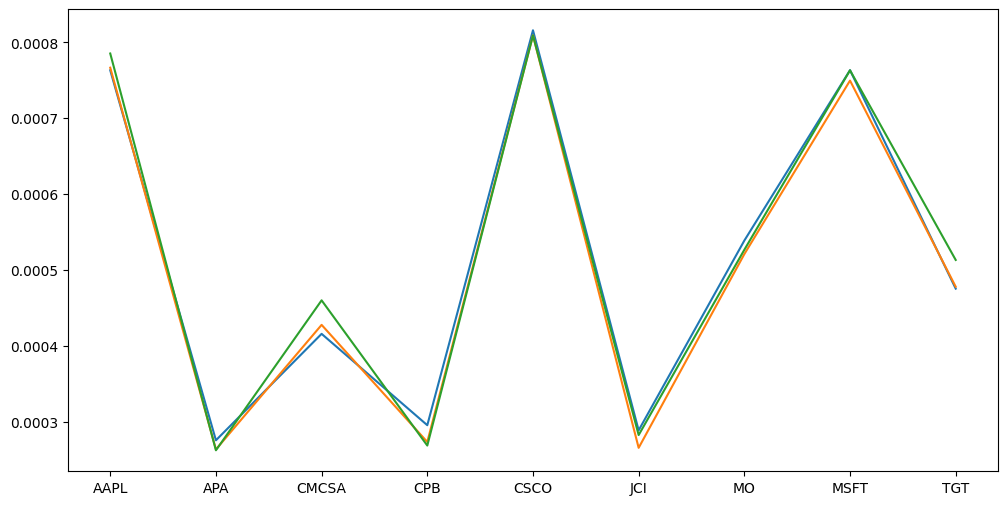

In [23]:
mean_20.mean(axis=0).plot(figsize=(12, 6), label='20 días')
mean_126.mean(axis=0).plot(label='126 días')
mean_252.mean(axis=0).plot(label='252 días')
plt.show()

In [31]:
np.percentile(mean_20.loc[:, 'CPB'], 0.05)

-0.014234930889379351

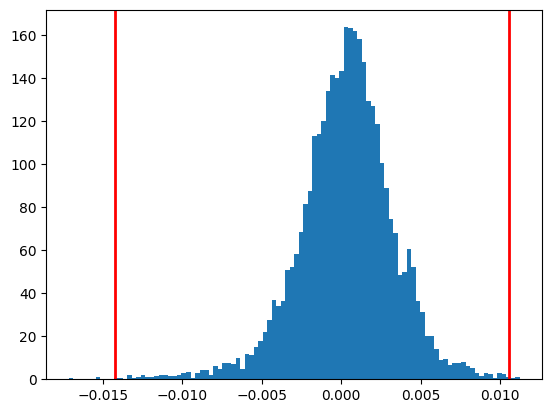

In [37]:
plt.hist(mean_20.loc[:, 'CPB'], bins=100, density=True, label='20 días')
# Línea vertical
plt.axvline(x=np.percentile(mean_20.loc[:, 'CPB'], 0.05), color='red', linewidth=2)
plt.axvline(x=np.percentile(mean_20.loc[:, 'CPB'], 99.95), color='red', linewidth=2)
plt.show()

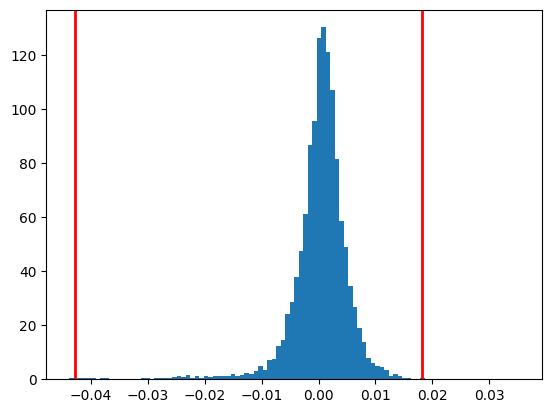

In [38]:
plt.hist(mean_20.loc[:, 'JCI'], bins=100, density=True, label='20 días')
# Línea vertical
plt.axvline(x=np.percentile(mean_20.loc[:, 'JCI'], 0.05), color='red', linewidth=2)
plt.axvline(x=np.percentile(mean_20.loc[:, 'JCI'], 99.95), color='red', linewidth=2)
plt.show()

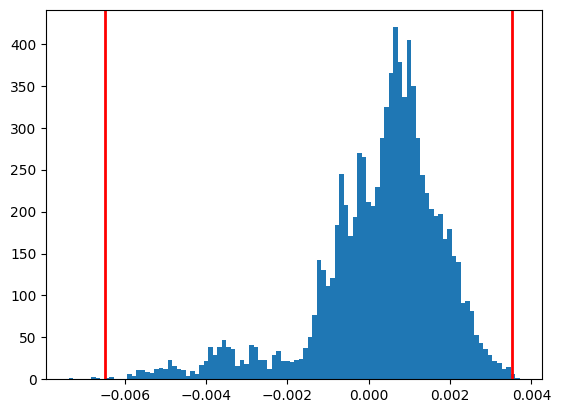

In [39]:
plt.hist(mean_252.loc[:, 'JCI'], bins=100, density=True, label='20 días')
# Línea vertical
plt.axvline(x=np.percentile(mean_252.loc[:, 'JCI'], 0.05), color='red', linewidth=2)
plt.axvline(x=np.percentile(mean_252.loc[:, 'JCI'], 99.95), color='red', linewidth=2)
plt.show()

In [26]:
100 * (mean_20.mean(axis=0) - mean_126.mean(axis=0))/mean_20.mean(axis=0)


AAPL    -0.446989
APA      4.370127
CMCSA   -2.847391
CPB      7.470602
CSCO     0.826049
JCI      7.980844
MO       3.308762
MSFT     1.797540
TGT     -0.529910
dtype: float64